In [69]:
import numpy as np
import pandas as pd
import MLP
import matplotlib.pyplot as plt
import torch
import time
import importlib
importlib.reload(MLP)
import seaborn as sns


In [70]:
def create_dataset(filename: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # read data
    df = pd.read_csv(filename)

    # split data
    x, y_noise, y_true = df['x'], df['y_noise'], df['y_true']
    return x, y_noise, y_true

In [71]:
def evaluate_model(cfg : dict, foldername : str) -> dict:
    results = {"train_loss": [], "test_loss": 0, "x_train": [], "y_train": [], "x_test": [],
                "y_test": [], "y_train_pred": [], "y_test_pred": [], "x_plot_trainvals": [], "x_plot_testvals": [],}
    # get configs
    model_name = cfg["name"]
    input_size = cfg["input_size"]
    hidden_sizes = cfg["hidden_sizes"]
    output_size = cfg["output_size"]
    n_epochs = cfg["n_epochs"]
    
    train_file = f"{foldername}/train_data.csv"
    test_file = f"{foldername}/test_data.csv"
    val_file = f"{foldername}/validation_data.csv"
    # create dataset
    train_data= create_dataset(train_file)
    test_data = create_dataset(test_file)
    val_data = create_dataset(val_file)
    true_vals = create_dataset(f"{foldername}/true_data.csv")
    # change x-values to shape (n, 1)
    x_train = torch.tensor(train_data[1].values.reshape(len(train_data[1]), 1)).float()
    y_train = torch.tensor(train_data[2].values.reshape(len(train_data[1]), 1)).float()
    x_test = torch.tensor(test_data[1].values.reshape(len(test_data[1]), 1)).float().view(-1, 1)
    y_test = torch.tensor(test_data[2].values.reshape(len(test_data[1]), 1)).float()
    x_val = torch.tensor(val_data[1].values.reshape(len(val_data[1]), 1)).float().view(-1, 1)
    y_val = torch.tensor(val_data[2].values.reshape(len(val_data[1]), 1)).float()

    x_plot_trainvals = train_data[0]
    x_plot_testvals = test_data[0]
    x_plot_valvals = val_data[0]


    # append to results
    results["x_train"] = x_train
    results["y_train"] = y_train
    results["x_test"] = x_test
    results["y_test"] = y_test
    results["x_val"] = x_val
    results["y_val"] = y_val
    results["x_plot_trainvals"] = x_plot_trainvals
    results["x_plot_testvals"] = x_plot_testvals
    results["x_plot_valvals"] = x_plot_valvals
    results["true_data_x"] = true_vals[0]
    results["true_data_ynoise"] = true_vals[1]
    results["true_data_y"] = true_vals[2]


    # train model
    model = MLP.MLP(input_size, hidden_sizes, output_size)
    # set val data
    model.set_val_data(x_val, y_val)

    start = time.time()
    model.fit(x_train,y_train,n_epochs)
    end = time.time()
    print(f"Training time for model: {model_name} was: {end - start}")
    results["training_time"] = end - start
    results["train_loss"] = model.loss_list
    results["val_loss"] = model.val_loss_list


    # test loss
    y_pred = model.predict(x_test)
    results["y_val_pred"] = model.predict(x_val)
    test_loss = model.loss_function(y_pred, y_test)
    results["test_loss"] = test_loss
    results["y_test_pred"] = y_pred
    print(f"Test loss for model: {model_name} was: {test_loss}")

    # append to results
    results["y_train_pred"] = model.predict(x_train)

    return results

In [72]:
configs = [
    {"name": "model1",
    "input_size" : 1,
    "hidden_sizes" : [8,8],
    "output_size" : 1,
    "n_epochs": 5000},
    {"name": "model2",
    "input_size" : 1,
    "hidden_sizes" : [25,25, 25, 25],
    "output_size" : 1,
    "n_epochs": 5000}
]
results = {}
foldername = "../datasets/pink_sin_test2"
for cfg in configs:
    if cfg["name"] not in results:
        results[cfg["name"]] = {}
    results[cfg["name"]] = evaluate_model(cfg, foldername)

  0%|          | 0/4999 [00:00<?, ?it/s]

100%|██████████| 4999/4999 [00:11<00:00, 452.59it/s]


Training time for model: model1 was: 11.051555156707764
Test loss for model: model1 was: 0.03363581746816635


100%|██████████| 4999/4999 [00:17<00:00, 291.98it/s]

Training time for model: model2 was: 17.12516450881958
Test loss for model: model2 was: 0.0351850725710392


In [73]:
def plot_model(model_res : dict) -> None:
     # Create a figure with two subplots side by side
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    X_val = model_res["x_plot_valvals"]
    KAN_preds = model_res["y_val_pred"]
    y_noise_val = model_res["x_val"]
    X_tot = model_res["true_data_x"]
    y_true_tot = model_res["true_data_y"]
    ax[0].plot(X_val, y_noise_val, "o", markersize=1, linestyle='None', label="val data")
    ax[0].plot(X_tot, y_true_tot, "-",label='True function')
    #ax[0].plot(X, y_true, "-",label='True trained function')

    # Sort the values for better visualization
    indices = X_val.argsort()
    sorted_X = X_val[indices]


    # sort the predictions using the same indices as the sorted X values
    sorted_KAN_preds = KAN_preds[indices]

    #print("sorted_KAN_preds",sorted_KAN_preds.shape)
    ax[0].plot(sorted_X, sorted_KAN_preds, "--", label='KAN predictions')

    #noise_x = np.linspace(-10, 10, 1000)
    #noise_combined = 0.0001*noise_x#np.sin(noise_x) + np.sin(0.2 * noise_x)
    

    ax[0].set_xlabel("Random X 1D samples")
    ax[0].set_ylabel("Function")
    ax[0].legend()


    # --- Plot 2: Training and Validation Loss ---
    # Convert loss data to a DataFrame for Seaborn
    loss_df = pd.DataFrame({
        'Epoch': range(1, len(model_res['train_loss']) + 1),
        'Train Loss': model_res['train_loss'],
        'Validation Loss': model_res['val_loss']
    })

    # Ensure correct data types
    loss_df['Epoch'] = loss_df['Epoch'].astype(int)
    loss_df['Train Loss'] = loss_df['Train Loss'].astype(float)
    loss_df['Validation Loss'] = loss_df['Validation Loss'].astype(float)
    
    # Melt the DataFrame for easier plotting with Seaborn
    loss_melted = loss_df.melt(id_vars='Epoch', var_name='Loss Type', value_name='Loss')

    # Debugging: Inspect the melted DataFrame
    print("Melted Loss DataFrame:")
    print(loss_melted.head())

    # Line plot for training and validation loss, with no fancy stuff
    sns.lineplot(data=loss_melted, x='Epoch', y='Loss', hue='Loss Type', ax=ax[1])

    # Set labels and title
    ax[1].set_xlabel("Epoch", fontsize=12)
    ax[1].set_ylabel("Loss", fontsize=12)
    ax[1].set_title("Training and Validation Loss Over Epochs", fontsize=14, weight='bold')

    # Customize legend
    ax[1].legend(title='Loss Type', fontsize=10, title_fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Optional: Save the figure with high resolution
    # plt.savefig('enhanced_plots.png', dpi=300)

    # Display the plots
    plt.show()

    plt.show()

Melted Loss DataFrame:
   Epoch   Loss Type      Loss
0      1  Train Loss  0.665299
1      2  Train Loss  0.606953
2      3  Train Loss  0.553789
3      4  Train Loss  0.506258
4      5  Train Loss  0.464591


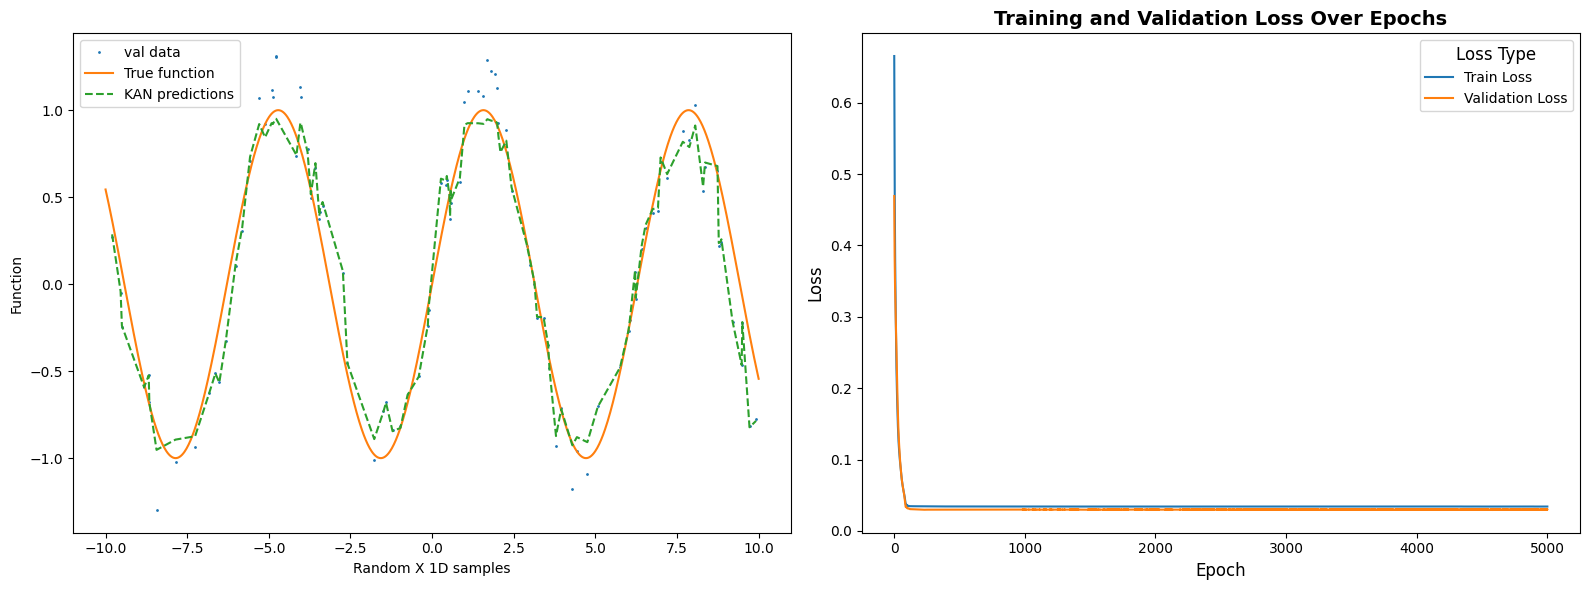

In [74]:
plot_model(results["model1"])

In [75]:
temp = results["model1"]["y_test_pred"]
temp2 = results["model1"]["y_test"]

print(temp)
print("---------")
print(temp2)

tensor([[-0.8319],
        [ 0.7781],
        [ 0.1632],
        [-0.6356],
        [ 0.9305],
        [-0.8226],
        [ 0.5190],
        [-0.0439],
        [-0.3396],
        [ 0.9522],
        [-0.2863],
        [-0.8114],
        [-0.1729],
        [ 0.9191],
        [-0.1018],
        [ 0.9613],
        [ 0.6697],
        [-0.3596],
        [ 0.9331],
        [-0.8759],
        [ 0.9063],
        [ 0.9317],
        [ 0.1878],
        [ 0.5414],
        [-0.8836],
        [ 0.7603],
        [ 0.5598],
        [ 0.8985],
        [ 0.9590],
        [ 0.9370],
        [-0.7461],
        [-0.8674],
        [ 0.1505],
        [ 0.8477],
        [ 0.1728],
        [ 0.4417],
        [-0.6611],
        [ 0.4538],
        [ 0.8098],
        [-0.2831],
        [ 0.9196],
        [ 0.1769],
        [ 0.8503],
        [ 0.3506],
        [-0.9491],
        [-0.6691],
        [ 0.1796],
        [ 0.7579],
        [ 0.9266],
        [-0.6553],
        [-0.9134],
        [-0.7506],
        [-0.